In [2]:
import numpy as np
from contextualized.dags.graph_utils import *
import time
import matplotlib.pyplot as plt
from contextualized.dags.losses import dag_loss_notears
import torch.optim as optim
%matplotlib inline

In [3]:
def project_to_dag_search_old(w):
    if is_dag(w):
        return w, 0.0
    
    w_dag = w.copy()
    w_dag = break_symmetry(w_dag)

    vals = sorted(list(set(np.abs(w_dag).flatten())))
    low = 0
    high = len(vals) - 1

    def binary_search(arr, low, high, w):  # low and high are indices
        # Check base case
        if high == low:
            return high
        if high > low:
            mid = (high + low) // 2
            if mid == 0:
                return mid
            result = trim_params(w, arr[mid])
            if is_dag(result):
                result2 = trim_params(w, arr[mid - 1])
                if is_dag(result2):  # middle value is too high.  go lower.
                    return binary_search(arr, low, mid - 1, w)
                else:
                    return mid  # found it
            else:  # middle value is too low.  go higher.
                return binary_search(arr, mid + 1, high, w)
        else:
            # Element is not present in the array
            print("this should be impossible")
            return -1

    idx = binary_search(vals, low, high, w_dag) + 1
    thresh = vals[idx]
    w_dag = trim_params(w_dag, thresh)

    # Now add back in edges with weights smaller than the thresh that don't violate DAG-ness.
    # want a list of edges (i, j) with weight in decreasing order.
    all_vals = np.abs(w_dag).flatten()
    idxs_sorted = reversed(np.argsort(all_vals))
    for idx in idxs_sorted:
        i = idx // w_dag.shape[1]
        j = idx % w_dag.shape[1]
        if np.abs(w[i][j]) > thresh:  # already retained
            continue
        w_dag[i][j] = w[i][j]
        if not is_dag(w_dag):
            w_dag[i][j] = 0.0
    assert is_dag(w_dag)
    return w_dag

In [4]:
def project_to_dag_ml(w, alpha=0.01, rho=0.01, lr=1e-3, max_iter=1000, debug_mode=False):
    """
    Project a weight matrix to the closest DAG using machine learning optimization
    """
    if is_dag(w):
        return w
    w_tensor = torch.tensor(w, dtype=torch.float32, requires_grad=True) # set requires_grad for auto optim
    optimizer = optim.Adam([w_tensor], lr=lr)

    for i in range(max_iter):
        optimizer.zero_grad()
        loss = dag_loss_notears(w_tensor, alpha=alpha, rho=rho)
        loss.backward()
        optimizer.step()

    w_dag = w_tensor.detach().numpy()
    w_dag = break_symmetry(w_dag)

    # make a sorted list for binary search
    vals = sorted(list(set(np.abs(w_dag).flatten())))
    low = 0
    high = len(vals) - 1

    def binary_search(arr, low, high, w):  # low and high are indices
        # Check base case
        if high == low:
            return high
        if high > low:
            mid = (high + low) // 2
            if mid == 0:
                return mid
            result = trim_params(w, arr[mid])
            if is_dag(result):
                result2 = trim_params(w, arr[mid - 1])
                if is_dag(result2):  # middle value is too high.  go lower.
                    return binary_search(arr, low, mid - 1, w)
                else:
                    return mid  # found it
            else:  # middle value is too low.  go higher.
                return binary_search(arr, mid + 1, high, w)
        else:
            # Element is not present in the array
            print("this should be impossible")
            return -1

    idx = binary_search(vals, low, high, w_dag) + 1
    thresh = vals[idx]
    w_dag = trim_params(w_dag, thresh)


    if debug_mode:
        print(f"ml version shape: {w_dag.shape}")
        print(f"ml version dag: \n {w_dag}")
        print(f"is dag?: {is_dag(w_dag)}")
        print("------------------------")
    assert is_dag(w_dag)
    return w_dag

In [5]:
def project_to_dag_search_no_addback(W):
    W = W.copy()
    if ig.Graph.Weighted_Adjacency(W).is_dag():
        return W
    W_mag = np.abs(W)
    W_flat = W_mag.flatten()
    
    # Binary search for the minimum threshold where W is a DAG, O(|E|log|E|)
    weights = np.sort(W_flat)
    low = 0
    mid = 0
    high = len(weights) - 1
    while low < high - 1:
        new_mid = (low + high) // 2
        mid = new_mid
        if ig.Graph.Weighted_Adjacency(W * (W_mag > weights[mid])).is_dag():
            high = mid
        else:
            low = mid
    W_dag = W * (W_mag > weights[high])
    assert(is_dag(W_dag))
    return W_dag

### just sort, search(old), and ML

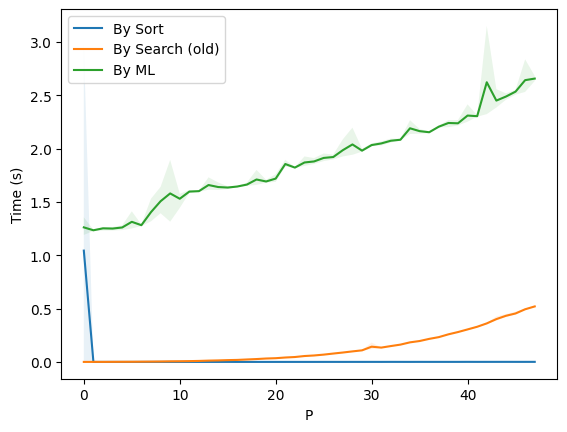

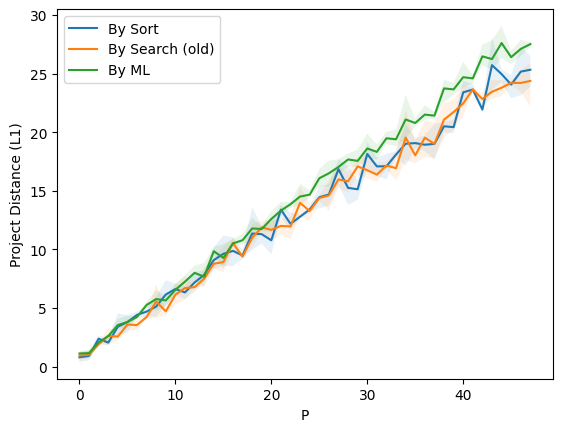

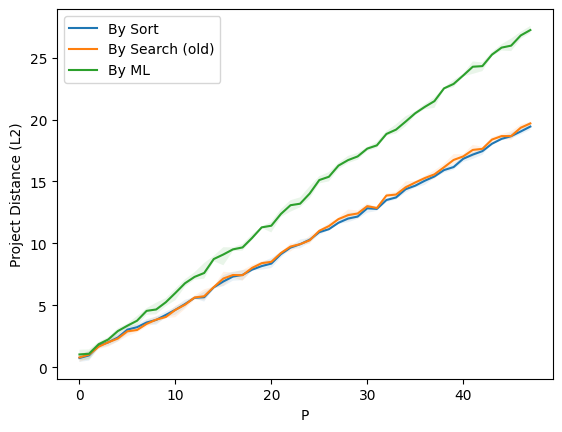

In [6]:
# times
sort_times = []
search_old_times = []
ml_times = []

# l1 distances
sort_dists_l1 = []
search_old_dists_l1 = []
ml_dists_l1 = []

# l2 distances
sort_dists_l2 = []
search_old_dists_l2 = []
ml_dists_l2 = []


for n in range(2, 50):
    my_sort_times = []
    my_search_old_times = []
    my_ml_times = []

    my_sort_dists_l2 = []
    my_search_old_dists_l2 = []
    my_ml_dists_l2 = []
    
    my_sort_dists_l1 = []
    my_search_old_dists_l1 = []
    my_ml_dists_l1 = []


    for k in range(3):
        w = np.random.uniform(-1, 1, size=(n,n))

        t = time.time()
        w_dag = project_to_dag_torch(w)
        my_sort_times.append(time.time() - t)
        my_sort_dists_l1.append(np.linalg.norm(w_dag - w, ord=1))
        my_sort_dists_l2.append(np.linalg.norm(w_dag - w))
        
        t = time.time()
        w_dag = project_to_dag_search_old(w)
        my_search_old_times.append(time.time() - t)
        my_search_old_dists_l1.append(np.linalg.norm(w_dag - w, ord=1))
        my_search_old_dists_l2.append(np.linalg.norm(w_dag - w))

        t = time.time()
        w_dag = project_to_dag_ml(w, rho=0.01, alpha=0.01, lr=0.01, debug_mode=False)
        my_ml_times.append(time.time() - t)
        my_ml_dists_l1.append(np.linalg.norm(w_dag - w, ord=1))
        my_ml_dists_l2.append(np.linalg.norm(w_dag - w))
        
        
    sort_times.append(my_sort_times)
    sort_dists_l1.append(my_sort_dists_l1)
    sort_dists_l2.append(my_sort_dists_l2)

    search_old_times.append(my_search_old_times)
    search_old_dists_l1.append(my_search_old_dists_l1)
    search_old_dists_l2.append(my_search_old_dists_l2)

    ml_times.append(my_ml_times)
    ml_dists_l1.append(my_ml_dists_l1)
    ml_dists_l2.append(my_ml_dists_l2)
    
def plot_results(results, label):
    results = np.array(results)
    plt.plot(np.mean(results, axis=1), label=label)
    plt.fill_between(range(len(results)),
                     np.percentile(results, 2.5, axis=1),
                     np.percentile(results, 97.5, axis=1),
                    alpha=0.1)
plot_results(sort_times, "By Sort")
plot_results(search_old_times, "By Search (old)")
plot_results(ml_times, "By ML")
plt.xlabel("P")
plt.ylabel("Time (s)")
plt.legend()

# plotting l1 distance results
plt.figure()
plot_results(sort_dists_l1, "By Sort")
plot_results(search_old_dists_l1, "By Search (old)")
plot_results(ml_dists_l1, "By ML")
plt.xlabel("P")
plt.ylabel("Project Distance (L1)")
plt.legend()

# plotting l2 distance results
plt.figure()
plot_results(sort_dists_l2, "By Sort")
plot_results(search_old_dists_l2, "By Search (old)")
plot_results(ml_dists_l2, "By ML")
plt.xlabel("P")
plt.ylabel("Project Distance (L2)")
plt.legend()

### plotting all

In [ ]:
# times
sort_times = []
search_times = []
search_old_times = []
ml_times = []
search_times_noaddback = []

# l1 distances
sort_dists_l1 = []
search_dists_l1 = []
search_old_dists_l1 = []
ml_dists_l1 = []
search_dists_noaddback_l1 = []

# l2 distances
sort_dists_l2 = []
search_dists_l2 = []
search_old_dists_l2 = []
ml_dists_l2 = []
search_dists_noaddback_l2 = []


for n in range(2, 50):
    my_sort_times = []
    my_search_times = []
    my_search_old_times = []
    my_ml_times = []
    my_search_noaddback_times = []

    my_search_dists_l2 = []
    my_sort_dists_l2 = []
    my_search_old_dists_l2 = []
    my_ml_dists_l2 = []
    my_search_noaddback_dists_l2 = []
    
    my_search_dists_l1 = []
    my_sort_dists_l1 = []
    my_search_old_dists_l1 = []
    my_ml_dists_l1 = []
    my_search_noaddback_dists_l1 = []


    for k in range(3):
        w = np.random.uniform(-1, 1, size=(n,n))

        t = time.time()
        w_dag = project_to_dag_search(w)
        my_search_times.append(time.time() - t)
        my_search_dists_l1.append(np.linalg.norm(w_dag - w, ord=1))
        my_search_dists_l2.append(np.linalg.norm(w_dag - w))
        
        t = time.time()
        w_dag = project_to_dag_torch(w)
        my_sort_times.append(time.time() - t)
        my_sort_dists_l1.append(np.linalg.norm(w_dag - w, ord=1))
        my_sort_dists_l2.append(np.linalg.norm(w_dag - w))
        
        t = time.time()
        w_dag = project_to_dag_search_old(w)
        my_search_old_times.append(time.time() - t)
        my_search_old_dists_l1.append(np.linalg.norm(w_dag - w, ord=1))
        my_search_old_dists_l2.append(np.linalg.norm(w_dag - w))

        t = time.time()
        w_dag = project_to_dag_ml(w, rho=0.01, alpha=0.01, lr=0.01, debug_mode=False)
        my_ml_times.append(time.time() - t)
        my_ml_dists_l1.append(np.linalg.norm(w_dag - w, ord=1))
        my_ml_dists_l2.append(np.linalg.norm(w_dag - w))
        
        t = time.time()
        w_dag = project_to_dag_search_no_addback(w)
        my_search_noaddback_times.append(time.time() - t)
        my_search_noaddback_dists_l1.append(np.linalg.norm(w_dag - w, ord=1))
        my_search_noaddback_dists_l2.append(np.linalg.norm(w_dag - w))

        
    sort_times.append(my_sort_times)
    sort_dists_l1.append(my_sort_dists_l1)
    sort_dists_l2.append(my_sort_dists_l2)

    search_times.append(my_search_times)
    search_dists_l1.append(my_search_dists_l1)
    search_dists_l2.append(my_search_dists_l2)

    search_old_times.append(my_search_old_times)
    search_old_dists_l1.append(my_search_old_dists_l1)
    search_old_dists_l2.append(my_search_old_dists_l2)

    ml_times.append(my_ml_times)
    ml_dists_l1.append(my_ml_dists_l1)
    ml_dists_l2.append(my_ml_dists_l2)
    
    search_times_noaddback.append(my_search_noaddback_times)
    search_dists_noaddback_l1.append(my_search_noaddback_dists_l1)
    search_dists_noaddback_l2.append(my_search_noaddback_dists_l2)
    

# plotting time results
def plot_results(results, label):
    results = np.array(results)
    plt.plot(np.mean(results, axis=1), label=label)
    plt.fill_between(range(len(results)),
                     np.percentile(results, 2.5, axis=1),
                     np.percentile(results, 97.5, axis=1),
                    alpha=0.1)
plot_results(sort_times, "By Sort")
plot_results(search_times, "By Search")
plot_results(search_old_times, "By Search (old)")
plot_results(ml_times, "By ML")
plot_results(search_times_noaddback, "By search (no edge addback)")
plt.xlabel("P")
plt.ylabel("Time (s)")
plt.legend()

# plotting l1 distance results
plt.figure()
plot_results(sort_dists_l1, "By Sort")
plot_results(search_dists_l1, "By Search")
plot_results(search_old_dists_l1, "By Search (old)")
plot_results(ml_dists_l1, "By ML")
plot_results(search_dists_noaddback_l1, "By Search (no edge addback)")
plt.xlabel("P")
plt.ylabel("Project Distance (L1)")
plt.legend()

# plotting l2 distance results
plt.figure()
plot_results(sort_dists_l2, "By Sort")
plot_results(search_dists_l2, "By Search")
plot_results(search_old_dists_l2, "By Search (old)")
plot_results(ml_dists_l2, "By ML")
plot_results(search_dists_noaddback_l2, "By Search (no edge addback)")
plt.xlabel("P")
plt.ylabel("Project Distance (L2)")
plt.legend()